In [166]:
import numpy as np
import matplotlib.pyplot as plt

import cuqi
from cuqi.testproblem import Deconvolution1D, Deconvolution2D
from cuqi.distribution import JointDistribution, Gaussian, CMRF, LMRF, GMRF
from cuqi.sampler import LinearRTO, pCN, CWMH, ULA, MALA, NUTS, MH
from cuqi.problem import BayesianProblem

# Simple spring system

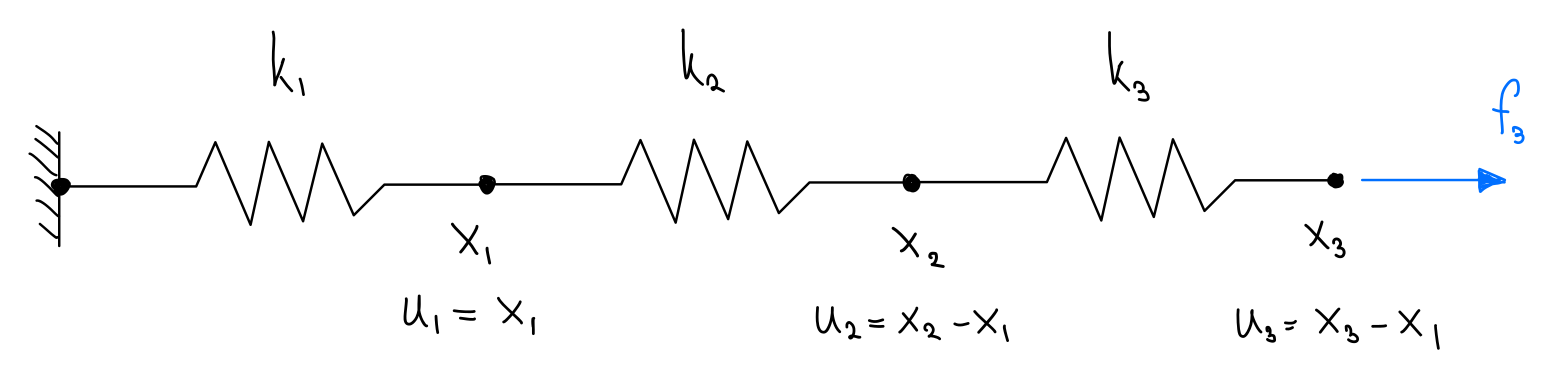

The data $y$ is a random variable containing the temperature measurements everywhere in the domain at the final time $\tau^\mathrm{max}$ corrupted by Gaussian noise:

$$u = \mathbf{K}(k) + \epsilon$$

In this example, the forward model is the solution to the finite element equations: $\bm{u}=\mathbf{K}(k)^{-1}\bm{f}$ that maps the external force vector, $\bm{f}$, to the displacement vecotr $\bm{u}$, and $\epsilon$ is the measurement noise.

## Three springs connected

Define the forward model $\bm{u}=\mathbf{K}^{-1}\bm{f}$

In [130]:
#This can be any function representing the forward computation. Here just a random function with 3 inputs and 2 outputs
def my_func(k):
    k = float(k)
    f = np.array([0.0, 0.0, 7.0])
    K = np.array(
        [[2.0*k    , -k       , 0.0     ],
         [-k     , 2*k      , -k   ],
         [0.0      , -k       , k    ]])
    u = np.linalg.solve(K, f)
    return u


In [131]:
model_func = cuqi.model.Model(my_func, range_geometry=3, domain_geometry=1)
print(model_func)

CUQI Model: _DefaultGeometry1D(1,) -> _DefaultGeometry1D(3,).
    Forward parameters: ['k'].


In [132]:
model_func(10000)

array([0.0007, 0.0014, 0.0021])

Generate some measured (fake) data, by setting a true value and assume some distribution on the noise

In [133]:
k_true = 100
u_true = model_func(k_true)
u_measure = u_true + 0.01*np.random.randn(3)

Plot the measured (fake) data 

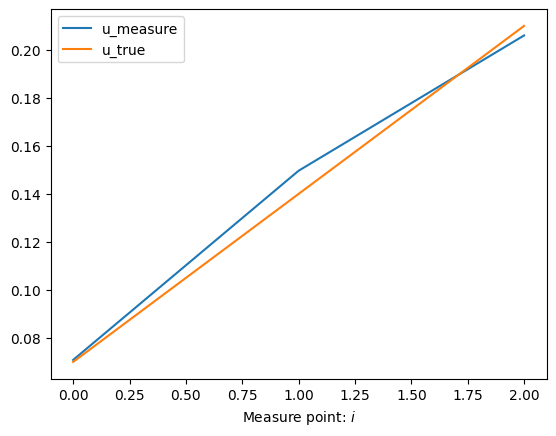

In [134]:
fig, ax = plt.subplots()
ax.plot(u_measure, label='u_measure')
ax.plot(u_true, label='u_true')
ax.set_xlabel('Measure point: $i$')
ax.legend()

Define prior

In [135]:
k = cuqi.distribution.Gaussian(k_true, 10)

Given the noise 
\begin{align*}
\mathbf{e} &\sim \mathrm{Gaussian}(\mathbf{0}, s_\mathbf{e}^2 \mathbf{I}).
\end{align*}
the likelihood becomes:
\begin{align*}
\pi( \bm{u} \mid k ) &\sim \mathrm{Gaussian}(\mathbf{K}(k)^{-1}\bm{f}, s_\mathbf{u}^2 \mathbf{I}),
\end{align*}

In [136]:
s_u = 0.1
u = cuqi.distribution.Gaussian(model_func(k), s_u)

In [137]:
joint = JointDistribution(u, k)

The posterior distribution pdf is given by the Bayes rule:
$$ p(x|y=y^\text{obs}) \propto p(y=y^\text{obs}|x)p(x) $$ 
By setting $y=\texttt{data}$ in the joint distribution we obtain the posterior distribution:

In [138]:
posterior = joint(u=u_measure)
print(posterior)

Posterior(
    Equation:
	 p(k|u) ∝ L(k|u)p(k)
    Densities:
	u ~ CUQI Gaussian Likelihood function. Parameters ['k'].
 	k ~ CUQI Gaussian.
 )


In [139]:
posterior.logpdf(10)

array([-434.10497053])

In [179]:
MySampler = MH(posterior)

In [180]:
posterior_samples = MySampler.sample_adapt(int(1e3))

Sample 1000 / 1000

Average acceptance rate: 0.872 MCMC scale: 1 



array([[<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

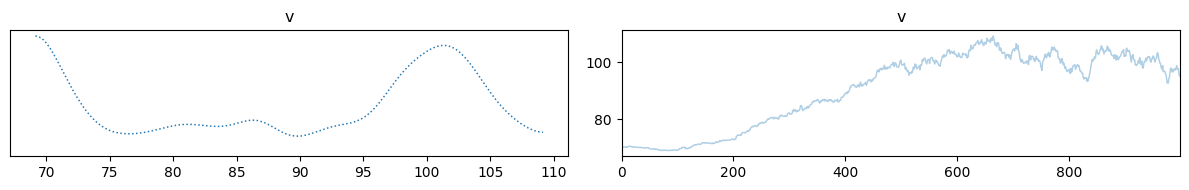

In [181]:
posterior_samples.plot_trace()

In [191]:
posterior_sample_burnthin = posterior_samples.burnthin(300, 3)

array([[<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

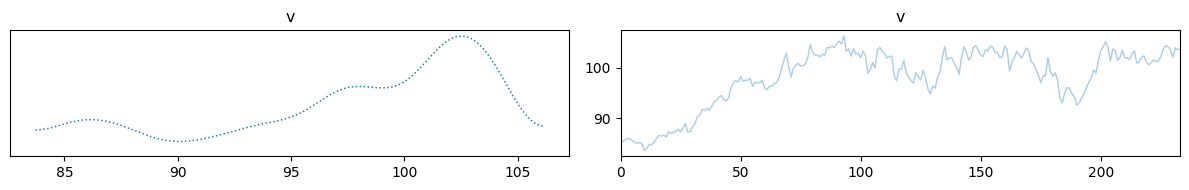

In [192]:
posterior_sample_burnthin.plot_trace()

Alternatively, the burn-in phase can be reduced by specifying a suitable initial guess:

Sample 1000 / 1000

Average acceptance rate: 0.877 MCMC scale: 1 



array([[<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

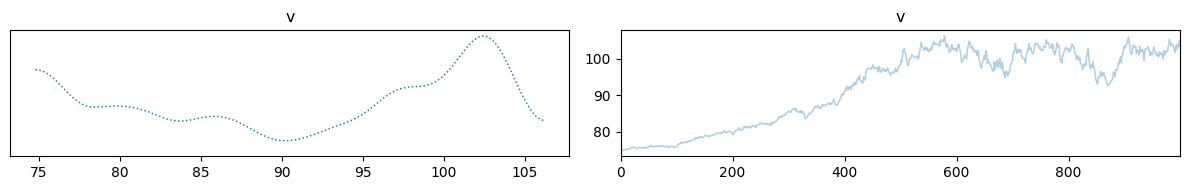

In [187]:
MySampler = MH(posterior,x0=75)
posterior_samples = MySampler.sample_adapt(int(1e3))
posterior_samples.plot_trace()

 None,

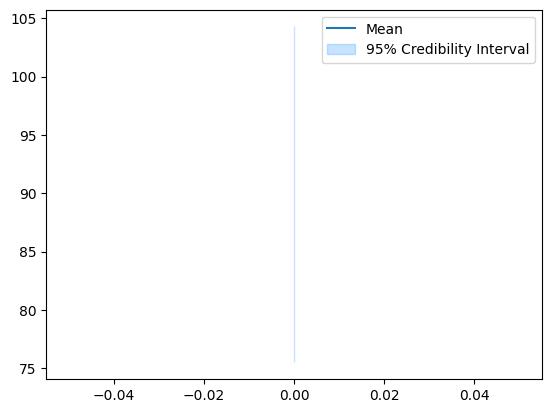

In [201]:
posterior_samples.plot_ci()

ValueError: x and y must have same first dimension, but have shapes (1,) and (3,)

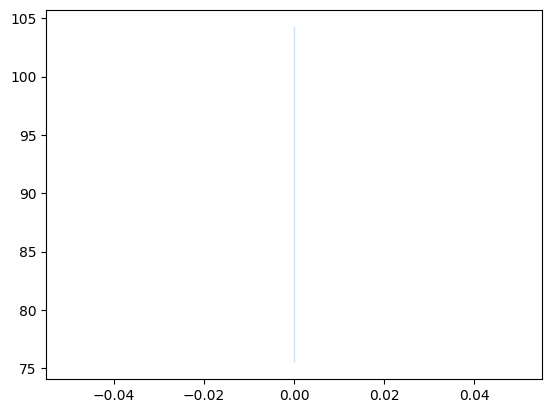

In [195]:
posterior_samples.plot_ci(95, exact=u_true)
